Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your github nickname below:

In [1]:
NICKNAME = "slava-qw"

---

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded
from numpy import linalg as LA

# Стационарное уравнение теплопроводности
Краевая задача уравнения теплопроводности с постоянным к-т тепло-ти может быть записанна в виде:
$$
-u'' + q(x)u = f(x), \; x\in[0, l]
$$
Рассмотрим граничное условие первого рода:
$$
u(0)=u_0 , u(l) = u_l
$$

## Сеточное решение

Введем сеточную функцию и апроксимируем задачу разностной схемой:
$$ 
u_i = u(t_i) = u(hi),\; i\in[0, N], h = \frac{l}{N}
$$

$$
-\frac{u_{i+1}-2u_i+u_{i-1}}{h^2} + q_i u_i = f_i
$$

Как обсуждалось на семинаре, это соотношение справедливо во внутренних точках, на краях же имеем условие $u[0]=u_0, u[N] = u_l$. Полученная ситема является СЛАУ с трёхдиагональной матрицей, которая может быть эффективно решена за линейное время (см. `scipy.linalg.solve_banded`). 

**Напишите функцию, реализующую изложенную методику** (можно использовать `solve_banded` или прогонку)

In [3]:
def heat_trans(q, f, u0, ul, l, N):
    """ Solve the heat trasfer equation `u_xx + q(x)u = f(x)` for x in (0; lx) with grid step h = l / N.
    
    Parameters
    ----------
    q: callable
        heat emission coef
    f: callable
        heat source
    u0 : real
       Boundary condition for x = 0
    ul : real
       Boundary condition for x = l
    N : integer
       Amount of spatial steps
       
    Returns
    -------
    u : ndarray, shape (N,)
        u[i] = u(t = h * i)
       
    """
    h = l / N

    # see here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_banded.html
    C = np.ones(N - 1) * ( -1 / h ** 2)
    C[0] = 0

    A = np.ones(N - 1) * ( -1 / h ** 2)
    A[-1] = 0

    B = np.zeros(N - 1)
    F = np.zeros(N - 1)

    for i in range(0, N - 1):
      k = i + 1
      B[i] = 2 / h ** 2 + q((i + 1) * h) # == B_(i+1), B[0] = B_1, B[1] = B_2
      F[i] = f((i + 1) * h) # == F_(i+1), F[0] = f_1 - A_1 * u0, F[1] = f_2, ..., F[N - 2] = F_(N-1) = f_(N-1) - C_(N-1) * ul
    F[0] -= ( - 1 / h ** 2) * u0
    F[-1] -= ( - 1 / h ** 2) * ul

    ab = np.array([C, B, A])
    u = np.array([u0, *solve_banded((1, 1), ab, F), ul])

    return u

## Анализ ошибки сеточного решения. Правило Рунге
Шаг сетки необходимо делать достаточно малым, чтобы решение мало отклонялось от истинного, однако более мелкий шаг требует большего машинного времени, поэтому остро встает вопрос об оценке этой погрешности для данного шага $h$



Рассмотрим следующую задачу:
 $$
 -u'' + x^2u = \left(\frac{\pi^2}{4}+x^2\right)\cos\frac{\pi}{2}x,\; x\in [0,1], u(0)=1, u(1)=0
 $$
 
Она может быть решена аналитически, $u_{exact} = \cos \frac{\pi}{2}x$, так что в данном случае можно точно найти ошибку сеточного решения:
$$
\epsilon_h(x_i) = u_h[x_i] - u_{exact}(x_i)
$$

Однако на практике, разумеется, точное решение неизвестно, и необходи получать такую оценку апостериорно.

Для этого необходимо сравнивать решения на стеках с различными $h$ (В духе критерия Коши про фундаментальную последовательность.)

В ситуации общего положения приходится ограничеваться грубой оценкой $|\epsilon_1(x)| \sim |u_1(x)-u_2(x)|  = \epsilon_1^{Cauchy}$, где $u_2$ - решение на предыдущей(более грубой сетке).

Однако часто из анализа схемы известна асимптотика погрешности
$\epsilon_h(x)  \sim C h^p$, у нас $p=2$, в этом случае **Правило Рунге** позволяет получить более точную оценку и улучшить решение.

Рассмотрим две сетки $h_1 = h, h_2 = 2h$, причем узлы сетки $1$ содержат узлы сетки $2$: $x_{i_2} = h_1 i_1 = h_2 i_2 \implies i_1 = 2i_2$

Тогда можено выписать значения погрешностей в этих узлах
$$
\epsilon_1(x) = u_1(x) - u(x) \approx C\, h^2,
$$


$$
\epsilon_2(x) = u_2(x) - u(x) \approx C\, 2^2 h^2
$$

Исключая $u(x), C$ можем найти оценку в общих узлах
$$
\epsilon_1 \approx \frac{u_2(x)-u_1(x)}{2^2-1} = \epsilon_1^{sim}
$$

    Заметим, что получив это мы можем улучшить наше решение u_1 в этих узлах:
$$
u_{1}^{sim}(x) = u_1(x) - \epsilon_1^{sim}(x) \;(\approx u_1(x)-\epsilon_1(x) = u(x))
$$

**Используя написанную вами функцию `heat_trans`, решите задачу выше с шагом $h_1 = h = 1/2^6$ и $h_2 = 2h$, постройте** 

- на одном графике точное значение ошибки $\epsilon^1$ , оценку этой ошибки по правилу Рунге $\epsilon^1_{sim}$
и "по Коши" $\epsilon_1^{Cauchy}$ (в точках $i_1 = 2 i_2$)
- на другом графике ошибку улучшенного решения $u_1^{sim}(x) - u(x) = \epsilon_1 - \epsilon_1^{sim}$

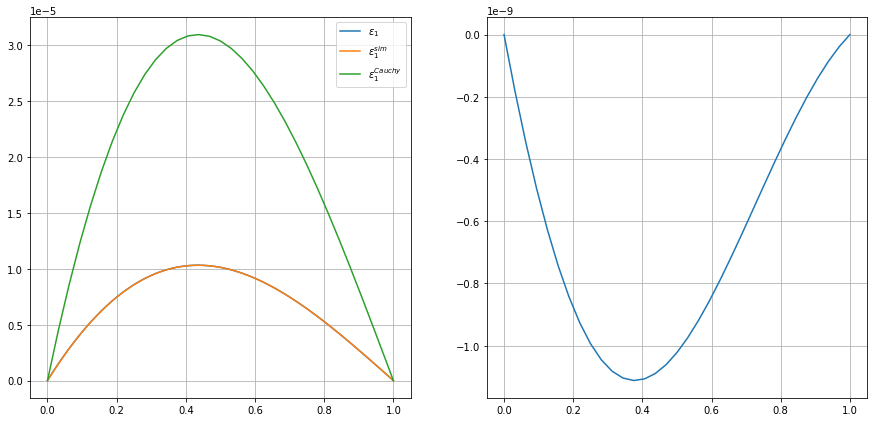

In [4]:
u0, ul = 1, 0
l, r = 1, 2
h0 = 2 ** (-6)

h_list = [h0, r * h0]
# u1 for grid with h1 = h
# u2 for grid with h2 = 2h
q = lambda x : x ** 2
f = lambda x : (np.pi ** 2 / 4 + x ** 2) * np.cos(np.pi * x / 2)

x_list = []
u_list = []
eps_list = []

for h in h_list:
  N = int(l / h)
  x = np.linspace(0, 1, N + 1)
  x_list.append(x)
  u_ex = np.cos(np.pi * x / 2)

  u_sol = heat_trans(q, f, u0, ul, l, N)

  u_list.append(u_sol)
  eps_list.append(u_sol - u_ex)

eps1 = eps_list[0]
eps_sim = (u_list[1] - u_list[0][::2]) / (r ** 2 - 1)
eps1_cauchy = np.abs(u_list[1] - u_list[0][::2])

fig, axes = plt.subplots(1, 2, figsize=(15,7))

ax1, ax2 = axes
ax1.plot(x_list[0], eps1, label=r'$\varepsilon_1$')
ax1.plot(x_list[1], eps_sim, label=r'$\varepsilon^{sim}_1$')
ax1.plot(x_list[1], eps1_cauchy, label=r'$\varepsilon^{Cauchy}_1$')
ax1.legend(loc='best')
ax1.grid(True)

ax2.plot(x_list[1], eps1[::2] - eps_sim)
ax2.grid(True)




**Какой порядок точности по $h$ имеет улучшенное решение (Объясните аналитически)?
Можно ли как-то получить улучшенное решение в оставшихся узлах сетки $1$ с той же точностью?**


Пусть есть функция $u(x)$ и её "приближенное" значение $y(x, h)$ на равномерной сетке с шагом $h$. То есть можно записать уравнение вида:

$$
u(x) = y(x, h) + \psi(x)h^p + O\left(h^{p+1}\right)
$$

где $p$ — порядок точности расчетной формулы, а $\psi(x) h^p$ — главный член погрешности.

Если провести расчет на другой сетке с шагом $rh$, то

$$
u(x) = y(x, rh) + \psi(x)(r h)^p + O\left((r h)^{p+1}\right)
$$

Значение главного члена погрешности определяется вычитанием выражений, полученных выше:

$$
\psi(x) h^p=\frac{y(x, h)-y(x, r h)}{r^p-1} + O\left(h^{p+1}\right)
$$


Следовательно, пользуясь расчетом на сетке с шагом $rh$, можно оценить главный член погрешности расчета на равномерной сетке с шагом $h$. Если подставить найденную погрешность, то результат будет вчеслен с более высокой точностью:

$$
u(x) = y(x, h)+\frac{y(x, h)-y(x, r h)}{r^p-1}+O\left(h^{p+1}\right)
$$

Откуда следует, что порядок точности этого приближенного решения равен $p + 1$, в то время как используемая разностная схема имела порядок точности равный $p$. Значит, используя еще одну стеку можно повысить на порядок точность вычислений.

В нашем случае $r = 2, \ p = 2$, а значит по выведенной выше формуле порядок точности равен $3$. Для получения той же точности в оставшихся узлах сетки 1 нужно прожелать тоже самое, но с вдвое меньшим шагом по сравнению с шагом сетки 1.

# Динамическое уравнение теплопроводности

Начально-краевая задача для уравнения теплопроводности с постоянным коэффициентом в общем виде можно записать следующим образом:
$$
\begin{array}{l}
\dfrac{\partial u}{\partial t} = \alpha \dfrac{\partial^2 u}{\partial x^2} - q(x,t)u+f(x, t), \; t > 0, \; x \in (0, l_x), \\
\left. u \right|_{t=0} = u_0(x), \\
\left. u \right|_{x=0} = \mu_1(t), \\
\left. u \right|_{x=l_x} = \mu_2(t),
\end{array}$$
где $u(x, t)$ - функция температуры, $\alpha = const$ - коэффициент теплопроводности, $f(x, t)$ - функция источника, $q(x,t)$ - к-т теплоотдачи. 

## Явная схема

Запишем разностное уравнение явной схемы:
$$\dfrac{y_i^{k+1} - y_i^{k}}{\tau} = \alpha \dfrac{y_{i+1}^{k} - 2 y_i^{k} + y_{i-1}^{k}}{h^2} - q_i^k y_i^k+ f_i^k,$$
где $\tau$ и $h$ - шаги по времени и пространству, $y_i^k$ - значение приближённого решения в точке $(i, k)$ сетки, $f_i^k$ - значение функции источника в той же точке сетки. 

Аппроксимируем начальное и граничные условия:
$$
\begin{array}{l}
y_i^0 = u_0(x_i), \; \forall i = \overline{0, N},\\
y_0^k = \mu_1(t_k), \\
y_N^k = \mu_2(t_k), \; \forall k > 0.
\end{array}$$

Запрограммируйте явную разностную схему решения начально-краевой задачи для однородного уравнения теплопроводности. Обратите внимание, что если парметры $q,f$ выходят на некоторую асимптотику по времени, то
$$\exists \lim\limits_{t \rightarrow \infty} u(x, t) = u_\infty (x).$$
поэтому расчёт в какой-то момент следует остановить (считать до установления).

Во время проведения расчетов помните о том, что явная схема *условно* устойчива.

    Это задание не сильно отличается от ранних дз на схемы Эйлера...

In [5]:
def heat_expl(init, bound1, bound2, alpha, lx, q, f, h=1e-2, tau=1e-4, tol=1e-5):
  """ Solve the heat equation `u_t = a*u_xx` for x in (0; lx) with an explicit scheme.
  
  Parameters
  ----------
  init : callable
      Initial condition - function of x
  bound1 : callable
      Boundary condition for x = 0 - function of t
  bound2 : callable
      Boundary condition for x = lx - function of t
  alpha : float
      Thermal diffusivity   
  q: callable
      heat emission coef - function of (x, t)
  f: callable
      heat source - function of (x, t)
  h : float
      Spatial step
  tau : float
      Time step
  tol : float, optional
      Target tolerance.
      Stop iterations when the 2-norm of the difference between 
      solution on this time step and the next is less the tol.
      
  Returns
  -------
  t_end : float
      End time of calculation
  u_end : ndarray, shape (N,)
      Limit u_∞(x) (See above)
  """
  N = int(lx / h)
  k = 1
  t_end = 0

  y_k = np.zeros(N)  # at the beginning of the loop, 'this' vector should be used
  y_kplus1 = np.ones(N + 1)
  perk = True
  while perk or LA.norm(y_kplus1 - y_k) >= tol:  # I want to run the loop once, and then, depending on the condition of their norm difference
    y_k = np.array(y_kplus1)
    if perk:
      y_k = np.array([init(i * h) for i in range(0, N + 1)])

    for i in range(1, N):
      y_kplus1[i] = tau * ((1 / tau - q(i * h, k * tau) - 2 * alpha / h ** 2) * y_k[i] + alpha / h ** 2 * y_k[i - 1] + alpha / h ** 2 * y_k[i + 1] + f(i * h, k * tau))
    y_kplus1[0], y_kplus1[-1] = bound1(k * tau), bound2(k * tau)  # y_kplus1 has a shape (N + 1,)
    t_end = k * tau
    perk = False
    k += 1

  u_end = y_kplus1

  return t_end, u_end

Протестируйте Вашу функцию.

In [6]:
from numpy.testing import assert_allclose


t_0, u_0 = heat_expl(init=lambda x: 0., bound1=lambda t: 1., bound2=lambda t: 1., 
                     alpha=1, lx=1, h=0.1, tau=0.005, q=lambda x, t: 0, f=lambda x, t: 0, tol=1e-3)


assert_allclose(u_0, np.ones(11), atol=1e-2)

t_1, u_1 = heat_expl(init=lambda x: x**2, bound1=lambda t: 0., bound2=lambda t: 1., 
                     alpha=1, lx=1, h=0.01, tau=1e-5, q=lambda x, t: -np.pi ** 2 / 4, f=lambda x, t: 0, tol=1e-7)


x = np.linspace(0, 1, 100 + 1, endpoint=True)
assert_allclose(u_1, np.sin(np.pi / 2 * x), atol=1e-2)


Определите порядки точности схемы (по пространству и времени) на тестовой задаче: 
$$
\begin{array}{l}
\dfrac{\partial u}{\partial t} = \dfrac{\partial^2 u}{\partial x^2} +1, \; t > 0, \; x \in (0, 1), \\
\left. u \right|_{t=0} = 0, 
\left. u \right|_{x=0} = 0, 
\left. u \right|_{x=1} = 0,\\
u(t\to+\infty)= \frac{x(1-x)}{2}
\end{array}$$


Для этого выберите некоторый момент времени $t_c \in (0, 0.2)$.

1. Сделайте несколько расчётов для разных значений пространственного шага (например, $h_0, \; 2 h_0, \; 4 h_0 \; 8h_0, ...$). 
Оцените погрешности "по Коши" $\epsilon_h(t_c) = max_{x}(|u_h(t_c) - u_{2h}(t_c)|)$. Постройте график $\epsilon_h(h)$. Определите порядок схемы.
2. Проделате аналогичную процедуру, варьируя шаг по времени $\tau_0, 2\tau_0, ...$.
3. Обратите внимание, что имеющуюся функцию `heat_expl` надо немного модифицировать. Помните про условную стабильность!
3. Найдите отношения этих ошибок. Сопоставьте полученные величины с порядком аппроксимации схемы по данной переменной. 

In [7]:
# the main condition here is that tau / h ** 2 <= 1 / 2
# and we should continue our calculations until t = k * tau <= t_c

def heat_expl(init, bound1, bound2, alpha, lx, q, f, t_c, h=1e-2, tau=1e-4):
  N = int(lx / h)
  k = 1
  t_end = 0
  y_k = np.zeros(N) # at the beginning of the loop, 'this' vector should be used
  y_kplus1 = np.ones(N + 1)
  perk = True
  while perk or k * tau <= t_c:  # I want to run the loop once, and then run it, depending on the condition of the time
    y_k = np.array(y_kplus1)
    if perk:
      y_k = np.array([init(i * h) for i in range(0, N + 1)])

    for i in range(1, N):
      y_kplus1[i] = tau * ((1 / tau - q(i * h, k * tau) - 2 * alpha / h ** 2) * y_k[i] + alpha / h ** 2 * y_k[i - 1] + alpha / h ** 2 * y_k[i + 1] + f(i * h, k * tau))
    y_kplus1[0], y_kplus1[-1] = bound1(k * tau), bound2(k * tau)  # y_kplus1 has a shape (N + 1,)
    t_end = k * tau
    perk = False
    k += 1

  u_end = y_kplus1

  return t_end, u_end


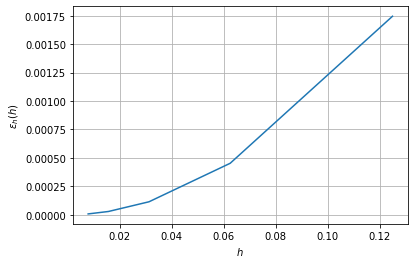

In [8]:
from math import log2

t_c = 0.1
h = 1 / 2 ** 2 # the max value of h-step
d = 5 # the number of points (d - 1) on the 'error' plot
# h <= (2 * tau) ** 0.5, so take h (the last member of h_list), the memeber before them is h / 2, before it is h / 4 and so on

# I want to get uniform step in time and coordinate for all steps in h_list1, and also that tau | t_c  and h_list1[i] | 1 for all i
h0 = h / 2 ** d
h_list1 = np.array([2 ** j * h0 for j in range(d + 1)]) 

# find tau that fit for this condition: tau / h_list1[0] ** 2 <= 1 / 2, where tau = t_c / 2 ** s
s = int(log2(2 * t_c / h_list1[0] ** 2)) + 1
tau = t_c / 2 ** s # so we will get s + 1 dots on time line

u_list = []
eps_list_h = []

for i in range(len(h_list1)): # for each h from {h0, 2 * h0, 4 * h0, 8 * h0, 16 * h0, ..., 2 ** d * h0}
  t, u = heat_expl(init=lambda x: 0., bound1=lambda t: 0., bound2=lambda t: 0., alpha=1, lx=1, h=h_list1[i], tau=tau, q=lambda x, t: 0, f=lambda x, t: 1, t_c=t_c)
  u_list.append(u)

u_arr = np.asarray(u_list, dtype=object)
for i in range(len(u_list) - 1):
  eps_list_h.append(max(np.abs(u_arr[i][::2] - u_arr[i + 1])))

plt.plot(h_list1[:-1], np.array(eps_list_h))
plt.xlabel('$h$')
plt.ylabel(r'$\varepsilon_{h}(h)$')
plt.grid(True)
plt.show()

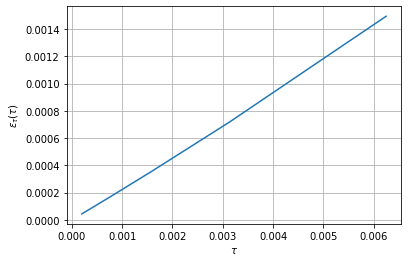

In [9]:
from math import log2, sqrt

t_c = 0.1
t = t_c / 2 ** 3 # the max value of tau-step
d = 6 # the number of points (d - 1) on the 'error' plot
# h <= (2 * tau) ** 0.5, so take t (the last member of tau_list1), the memeber before them is t / 2, before it is t / 4 and so on

# I want to get uniform step in time and coordinate for all steps in h_list1, and also that tau_list1[i] | t_c  and h | 1 for all i
tau0 = t / 2 ** d
tau_list1 = np.array([2 ** j * tau0 for j in range(d + 1)]) 

# find h that fit for this condition: tau_list1[-1] / h ** 2 <= 1 / 2, where h = 1 / 2 ** s
s = int(log2(1/ sqrt(2 * tau_list1[-1])))
h = 1 / 2 ** s # so we will get s + 1 dots on coordinate axis

u_list = []
eps_list_t = []

for i in range(len(tau_list1)): # for each tau from {tau0, 2 * tau0, 4 * tau0, 8 * tau0, 16 * tau0, ..., 2 ** d * tau0}
  t, u = heat_expl(init=lambda x: 0., bound1=lambda t: 0., bound2=lambda t: 0., alpha=1, lx=1, h=h, tau=tau_list1[i], q=lambda x, t: 0, f=lambda x, t: 1, t_c=t_c)
  u_list.append(u)

u_arr = np.asarray(u_list, dtype=object)
for i in range(len(u_list) - 1):
  eps_list_t.append(max(np.abs(u_arr[i] - u_arr[i + 1])))

plt.plot(tau_list1[:-1], np.array(eps_list_t))
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\varepsilon_{\tau}(\tau)$')
plt.grid(True)
plt.show()

In [10]:
np.array(eps_list_h) / np.array(eps_list_t)[:-1]

array([0.16631416, 0.33160798, 0.6585761 , 1.29380343, 2.44243018])

Как видно из построенных графиков, порядок аппроксимации данной схемы $O(\tau, h^2)$. Причем порядок точности схемы определяется ее порядком
аппроксимации.

## Неявная схема 

Запишем разностное уравнение неявной схемы:
$$\dfrac{y_i^{k+1} - y_i^{k}}{\tau} = \alpha \dfrac{y_{i+1}^{k+1} - 2 y_i^{k+1} + y_{i-1}^{k+1}}{h^2} - q_i^{k+1}y_i^{k+1}+ f_i^{k+1}.$$

Аппроксимировать начальное и граничные условия будем так же, как в случае явной схемы.

Запрограммируйте неявную разностную схему решения начально-краевой задачи для однородного уравнения теплопроводности.

Для решения системы линейных уравнений можно использовать встроенные функции `scipy`...

    Полезно вспонить код из 1 задания...

In [11]:
def heat_impl(init, bound1, bound2, alpha, lx, q, f, h=1e-2, tau=1e-4, tol=1e-5):
  """ Solve the heat equation `u_t = a*u_xx` for x in (0; lx) with  implicit scheme.
  
  Parameters
  ----------
  init : callable
      Initial condition - function of x
  bound1 : callable
      Boundary condition for x = 0 - function of t
  bound1 : callable
      Boundary condition for x = lx - function of t
  alpha : float
      Thermal diffusivity   
  q: callable
      heat emission coef - function of (x,t)
  f: callable
      heat source - function of (x,t)
  h : float
      Spatial step
  tau : float
      Time step
  tol : float, optional
      Target tolerance.
      Stop iterations when the 2-norm of the difference between 
      solution on this time step and the next is less the tol.
      
  Returns
  -------
  t_end : float
      End time of calculation
  u_end : ndarray, shape (N,)
      Limit u_∞(x) (See above)
  """

  k = 0
  N = int(lx / h)
  k = 1
  t_end = 0
  y_k = np.zeros(N)  # at the beginning of the loop, 'this' vector should be used
  y_kplus1 = np.ones(N + 1)
  perk = True


  while perk or LA.norm(y_kplus1 - y_k) >= tol:  # I want to run the loop once, and then, depending on the condition of their norm difference
    y_k = np.array(y_kplus1)
    if perk:
      y_k = np.array([init(i * h) for i in range(0, N + 1)])


    # y_kplus1 = ... (see also: https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_banded.html)

    C = np.ones(N - 1) * (-alpha / h ** 2)
    C[0] = 0

    A = np.ones(N - 1) * (-alpha / h ** 2)
    A[-1] = 0

    B = np.zeros(N - 1)
    F = np.zeros(N - 1)

    for i in range(0, N - 1):
      B[i] = 1 / tau + 2 * alpha / h ** 2 + q((i + 1) * h, k * tau)  # == B_(i+1), B[0] = B_1, B[1] = B_2
      F[i] = 1 / tau * y_k[i + 1] + f((i + 1) * h, k * tau)  # == F_(i+1), F[0] = f_1 - A_1 * u0, F[1] = f_2, ..., F[N-2] = F_(N-1) = f_(N-1) - C_(N-1) * ul
    F[0] -= (-alpha / h ** 2) * bound1(k * tau)
    F[-1] -= (-alpha / h ** 2) * bound2(k * tau)

    ab = np.array([C, B, A])
    y_kplus1 = np.array([bound1(k * tau), *solve_banded((1, 1), ab, F), bound2(k * tau)])

    t_end = k * tau
    perk = False
    k += 1

  u_end = y_kplus1

  return t_end, u_end

Протестируйте Вашу функцию.

In [12]:
from numpy.testing import assert_allclose


t_0,u_0 = heat_impl(init=lambda x: 0., bound1=lambda t: 1., bound2=lambda t: 1., 
                     alpha=1, lx=1, h=0.1, tau=0.005, q=lambda x,t:0. * x, f=lambda x,t:0. * x, tol=1e-3)
assert_allclose(u_0, np.ones(11), atol=1e-2)

t_1, u_1 = heat_impl(init=lambda x: x ** 2, bound1=lambda t: 0., bound2=lambda t: 1., 
                     alpha=1, lx=1, h=0.01, tau=1e-5, q=lambda x,t:-np.pi ** 2 / 4 + 0. * x, f=lambda x,t: 0. * x, tol=1e-7)


x = np.linspace(0, 1, 100 + 1, endpoint=True)
assert_allclose(u_1, np.sin(np.pi / 2 * x), atol=1e-2)


Определите порядки точности схемы (по пространству и времени) на тестовой задаче. (см. выше)

Определите порядки точности схемы (по пространству и времени) на тестовой задаче: 
$$
\begin{array}{l}
\dfrac{\partial u}{\partial t} = \dfrac{\partial^2 u}{\partial x^2} +1, \; t > 0, \; x \in (0, 1), \\
\left. u \right|_{t=0} = 0, 
\left. u \right|_{x=0} = 0, 
\left. u \right|_{x=1} = 0,\\
u(t\to+\infty)= \frac{x(1-x)}{2}
\end{array}$$


Для этого выберите некоторый момент времени $t_c \in (0, 0.2)$.

1. Сделайте несколько расчётов для разных значений пространственного шага (например, $h_0, \; 2 h_0, \; 4 h_0 \; 8h_0, ...$). 
Оцените погрешности "по Коши" $\epsilon_h(t_c) = max_{x}(|u_h(t_c) - u_{2h}(t_c)|)$. Постройте график $\epsilon_h(h)$. Определите порядок схемы.
2. Проделате аналогичную процедуру, варьируя шаг по времени $\tau_0, 2\tau_0, ...$.
3. Обратите внимание, что имеющуюся функцию `heat_impl` надо немного модифицировать.
3. Найдите отношения этих ошибок. Сопоставьте полученные величины с порядком аппроксимации схемы по данной переменной. 

In [13]:
def heat_impl(init, bound1, bound2, alpha, lx, q, f, t_c, h=1e-2, tau=1e-4):
  k = 0
  N = int(lx / h)
  k = 1
  t_end = 0
  y_k = np.zeros(N)  # at the beginning of the loop, 'this' vector should be used
  y_kplus1 = np.ones(N + 1)
  perk = True


  while perk or k * tau <= t_c:  # I want to run the loop once, and then, depending on the condition of the time
    y_k = np.array(y_kplus1)
    if perk:
      y_k = np.array([init(i * h) for i in range(0, N + 1)])


    # y_kplus1 = ... (see also: https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_banded.html)

    C = np.ones(N - 1) * (-alpha / h ** 2)
    C[0] = 0

    A = np.ones(N - 1) * (-alpha / h ** 2)
    A[-1] = 0

    B = np.zeros(N - 1)
    F = np.zeros(N - 1)

    for i in range(0, N - 1):
      B[i] = 1 / tau + 2 * alpha / h ** 2 + q((i + 1) * h, k * tau)  # == B_(i+1), B[0] = B_1, B[1] = B_2
      F[i] = 1 / tau * y_k[i + 1] + f((i + 1) * h, k * tau)  # == F_(i+1), F[0] = f_1 - A_1 * u0, F[1] = f_2, ..., F[N-2] = F_(N-1) = f_(N-1) - C_(N-1) * ul
    F[0] -= (-alpha / h ** 2) * bound1(k * tau)
    F[-1] -= (-alpha / h ** 2) * bound2(k * tau)

    ab = np.array([C, B, A])
    y_kplus1 = np.array([bound1(k * tau), *solve_banded((1, 1), ab, F), bound2(k * tau)])

    t_end = k * tau
    perk = False
    k += 1

  u_end = y_kplus1

  return t_end, u_end

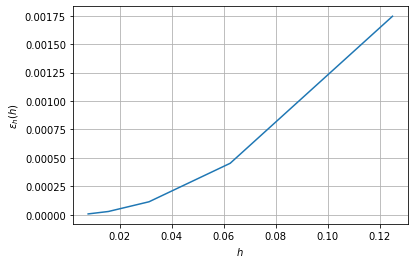

In [14]:
from math import log2

t_c = 0.1
h = 1 / 2 ** 2 # the max value of h-step
d = 5 # the number of points (d - 1) on the 'error' plot
# h <= (2 * tau) ** 0.5, so take h (the last member of h_list), the memeber before them is h / 2, before it is h / 4 and so on

# I want to get uniform step in time and coordinate for all steps in h_list1, and also that tau | t_c  and h_list1[i] | 1 for all i
h0 = h / 2 ** d
h_list1 = np.array([2 ** j * h0 for j in range(d + 1)]) 

# find tau that fit for this condition: tau / h_list1[0] ** 2 <= 1 / 2, where tau = t_c / 2 ** s
s = int(log2(2 * t_c / h_list1[0] ** 2)) + 1
tau = t_c / 2 ** s # so we will get s + 1 dots on time line

u_list = []
eps_list_h = []

for i in range(len(h_list1)): # for each h from {h0, 2 * h0, 4 * h0, 8 * h0, 16 * h0, ..., 2 ** d * h0}
  t, u = heat_impl(init=lambda x: 0., bound1=lambda t: 0., bound2=lambda t: 0., alpha=1, lx=1, h=h_list1[i], tau=tau, q=lambda x, t: 0, f=lambda x, t: 1, t_c=t_c)
  u_list.append(u)

u_arr = np.asarray(u_list, dtype=object)
for i in range(len(u_list) - 1):
  eps_list_h.append(max(np.abs(u_arr[i][::2] - u_arr[i + 1])))

plt.plot(h_list1[:-1], np.array(eps_list_h))
plt.xlabel('$h$')
plt.ylabel(r'$\varepsilon_{h}(h)$')
plt.grid(True)
plt.show()


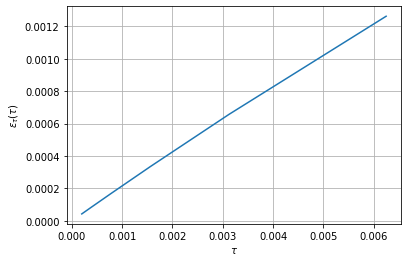

In [15]:
from math import log2, sqrt

t_c = 0.1
t = t_c / 2 ** 3 # the max value of tau-step
d = 6 # the number of points (d - 1) on the 'error' plot
# h <= (2 * tau) ** 0.5, so take t (the last member of tau_list1), the memeber before them is t / 2, before it is t / 4 and so on

# I want to get uniform step in time and coordinate for all steps in h_list1, and also that tau_list1[i] | t_c  and h | 1 for all i
tau0 = t / 2 ** d
tau_list1 = np.array([2 ** j * tau0 for j in range(d + 1)]) 

# find h that fit for this condition: tau_list1[-1] / h ** 2 <= 1 / 2, where h = 1 / 2 ** s
s = int(log2(1/ sqrt(2 * tau_list1[-1])))
h = 1 / 2 ** s # so we will get s + 1 dots on coordinate axis

u_list = []
eps_list_t = []

for i in range(len(tau_list1)): # for each tau from {tau0, 2 * tau0, 4 * tau0, 8 * tau0, 16 * tau0, ..., 2 ** d * tau0}
  t, u = heat_impl(init=lambda x: 0., bound1=lambda t: 0., bound2=lambda t: 0., alpha=1, lx=1, h=h, tau=tau_list1[i], q=lambda x, t: 0, f=lambda x, t: 1, t_c=t_c)
  u_list.append(u)

u_arr = np.asarray(u_list, dtype=object)
for i in range(len(u_list) - 1):
  eps_list_t.append(max(np.abs(u_arr[i] - u_arr[i + 1])))

plt.plot(tau_list1[:-1], np.array(eps_list_t))
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\varepsilon_{\tau}(\tau)$')
plt.grid(True)
plt.show()

In [16]:
np.array(eps_list_h) / np.array(eps_list_t)[:-1]

array([0.16715272, 0.33504766, 0.67248325, 1.34935464, 2.65710052])

Как видно из графиков выше, неявная разностная схема имеет такой же порядок аппроксимации, что и явная разностная схема, а именно $O(\tau, h^2)$, что также совпадает с теоретическими расчетами.